# How to break a neural network


We're going to use neural networks to make correct predictions!

THEN WE'RE GOING TO BREAK THEM.

In [1]:
# a bajillion imports
import shutil
import requests
import tempfile
import os
caffe_root = '/opt/caffe/'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Load the labels (so we know whether 242 means 'adorable puppy' or 'garbage can')
imagenet_labels_filename = caffe_root + '/data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !/opt/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')


Set Caffe to CPU mode because who even knows how to set up a GPU (not me)

In [3]:
caffe.set_mode_cpu()
# Load our model! trained by the GOOGLES! <3
def load_model():
    BATCH_SIZE = 1
    net = caffe.Net('/opt/caffe/models/bvlc_googlenet/deploy.prototxt',
                    '/models/bvlc_googlenet.caffemodel',
                    caffe.TEST)
    # change batch size to 1 for faster processing
    shape = list(net.blobs['data'].data.shape)
    shape[0] = BATCH_SIZE
    net.blobs['data'].reshape(*shape)
    net.blobs['prob'].reshape(BATCH_SIZE, )
    net.reshape() 
    return net
net = load_model()
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

If we're going to look at pictures of adorable dogs & pandas, we need a way to download them from the internet! This does that, and saves it to a png on our disk.

In [4]:
def get_png_image(url):
    fd, path = tempfile.mkstemp()
    tmpfile = os.fdopen(fd, "wb")
    response = requests.get(url, stream=True)
    shutil.copyfileobj(response.raw, tmpfile)
    !convert {path} {path}.png
    path = path + ".png"
    return transformer.preprocess('data', caffe.io.load_image(path))

Let's start with a simple classification.

Feed in the image (with some preprocessing) and classify with a forward pass.

In [5]:
cat_data = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))

In [6]:
print cat_data.shape

(3, 224, 224)


Great! The 3 means RGB, and the image is 224x224 pixels.

In [7]:
net.blobs['data'].data[...] = cat_data
out = net.forward()
pred_class = out['prob'][0].argmax()
print("Predicted class is #{}.".format(pred_class))

Predicted class is #282.


What did the input look like?

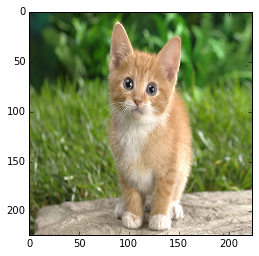

In [8]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

Adorable, but was our classification correct?

In [9]:
print labels[pred_class]

n02123159 tiger cat


Let's put all that together into a function -- make a prediction & show the image

In [10]:
def display(data):
    plt.imshow(transformer.deprocess('data', data))

def predict(data, n_preds=6, reload_model=True):
    if reload_model:
        net = load_model()
    net.blobs['data'].data[...] = data
    display(data)
    prob = net.forward()['prob']
    probs = prob[0]
    prediction = probs.argmax()
    top_k = probs.argsort()[::-1]
    for pred in top_k[:n_preds]:
        print "class: {cls}, label: {label}, certainty: {certainty}".format(
            cls=pred, label=labels[pred], certainty=probs[pred])
    return prob

In [11]:
net.data

AttributeError: 'Net' object has no attribute 'data'

In [ ]:
compute_gradient??

In [12]:
labels[169]

'n02090622 borzoi, Russian wolfhound'

In [13]:
np.sum(delta * grad)

NameError: name 'delta' is not defined

In [14]:
l

NameError: name 'l' is not defined

In [15]:
zip(range(1000), labels)

[(0, 'n01440764 tench, Tinca tinca'),
 (1, 'n01443537 goldfish, Carassius auratus'),
 (2,
  'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'),
 (3, 'n01491361 tiger shark, Galeocerdo cuvieri'),
 (4, 'n01494475 hammerhead, hammerhead shark'),
 (5, 'n01496331 electric ray, crampfish, numbfish, torpedo'),
 (6, 'n01498041 stingray'),
 (7, 'n01514668 cock'),
 (8, 'n01514859 hen'),
 (9, 'n01518878 ostrich, Struthio camelus'),
 (10, 'n01530575 brambling, Fringilla montifringilla'),
 (11, 'n01531178 goldfinch, Carduelis carduelis'),
 (12, 'n01532829 house finch, linnet, Carpodacus mexicanus'),
 (13, 'n01534433 junco, snowbird'),
 (14, 'n01537544 indigo bunting, indigo finch, indigo bird, Passerina cyanea'),
 (15, 'n01558993 robin, American robin, Turdus migratorius'),
 (16, 'n01560419 bulbul'),
 (17, 'n01580077 jay'),
 (18, 'n01582220 magpie'),
 (19, 'n01592084 chickadee'),
 (20, 'n01601694 water ouzel, dipper'),
 (21, 'n01608432 kite'),
 (22, 'n0

class: 388, label: n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca, certainty: 0.995689570904
hi

NameError: name 'compute_gradient' is not defined

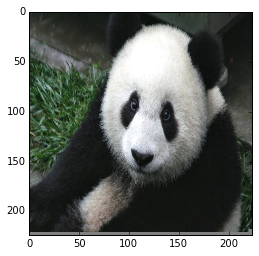

In [16]:
panda_url = 'https://upload.wikimedia.org/wikipedia/commons/c/cd/Panda_Cub_from_Wolong,_Sichuan,_China.JPG'
panda_data = get_png_image(panda_url)
probs = predict(panda_data, n_preds=1)
print 'hi', np.sum(np.abs(compute_gradient(probs)))
i = 270
probs[0][i] = 1
grad = compute_gradient(probs)
print 'hi', np.sum(np.abs(compute_gradient(probs)))
delta = np.sign(grad)
_ = predict(panda_data - 0.75 * delta, n_preds=1)

class: 412, label: n02747177 ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin, certainty: 0.405762076378


0.003674652

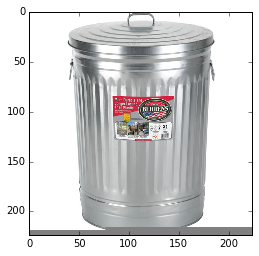

In [19]:
garbage_url = 'http://www.behrensmfg.com/wp-content/uploads/1270-31-gallon-trash-can.jpg'
garbage_data = get_png_image(garbage_url)
probs = predict(garbage_data, n_preds=1)
np.sum(np.abs(compute_gradient(probs)))

In [ ]:
sword_url = 'http://a.tgcdn.net/images/products/zoom/f2bc_sting_the_sword_of_bilbo_baggins.jpg'
sword_data = get_png_image(sword_url)
probs = predict(sword_data, n_preds=1)
np.sum(np.abs(compute_gradient(probs)))

In [ ]:
kitten_url = 'https://upload.wikimedia.org/wikipedia/commons/b/b9/CyprusShorthair.jpg'
kitten_data = get_png_image(kitten_url)
probs = predict(kitten_data, n_preds=1)

In [ ]:
dog_url = 'http://cdn.playbuzz.com/cdn/7820ec56-cd7d-487c-87ba-30ca87219dc4/26084bf6-4235-4f8f-9c2f-b7294ea62c15.jpg'
dog_data = get_png_image(dog_url)
probs = predict(dog_data, n_preds=1)
np.sum(np.abs(compute_gradient(probs)))

In [ ]:
queen_url = 'http://www.librarising.com/astrology/celebs/images2/QR/queenelizabethii.jpg'
queen_data = get_png_image(queen_url)
probs = predict(queen_data, n_preds=1)
np.sum(np.abs(compute_gradient(probs)))

In [ ]:
fence_url = 'http://jmarvinhandyman.com/wp-content/uploads/2014/04/fence-mossy-oak-wood-shadowbox_1373304.jpg'
fence_data = get_png_image(fence_url)
probs = predict(fence_data, n_preds=6)
print np.sum(np.abs(compute_gradient(probs)))

# Intentionally breaking the predictions.

Now it's time for the fun part. When is a garbage can not a garbage can?

When it's a cocktail shaker, or a water jug.

When is a panda not a panda? When it's another furry mammal. Let me show you what I mean.

In [ ]:
x = panda_data

In [ ]:
input_data = garbage_data

In [ ]:
output = predict(input_data, n_preds=1)

Just a normal panda. No big deal. Now, let's calculate the gradient of the network there!

In [18]:
def compute_gradient(probs):
    backout = net.backward(prob=probs)
    return backout['data'].copy()

In [ ]:
grad = compute_gradient(output)

What does it look like? (we need to scale it up to make it really visible)

In [ ]:
display(grad / np.percentile(grad, 98))

Okay, now here's the trick. We want to maximize the amount we're going to change our loss function by. Near our image, the loss function is something like f(image + delta) = f(image) + grad * delta.

So, let's set delta to sign(delta)!

In [ ]:
delta = np.sign(grad)

This is how much we're going to change our loss function by! 0.00002? Okay, fine, I guess.

In [ ]:
np.sum(grad * delta)

Just to get a sense -- what would it have been if we picked a random direction?

In [ ]:
np.sum(grad * np.random.randint(-1, 1, grad.shape))

Well, we're doing about 1000x better than if we picked a random direction. Let's go!

In [ ]:
_ = predict(input_data - 0.15 * delta, n_preds=1)

Uh, sure. Looks great.

class: 885, label: n04525038 velvet, certainty: 0.273825019598
class: 885, label: n04525038 velvet, certainty: 0.297779291868
class: 885, label: n04525038 velvet, certainty: 0.317116200924
class: 885, label: n04525038 velvet, certainty: 0.342717021704


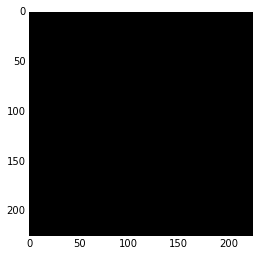

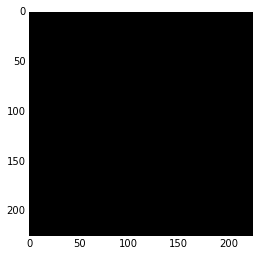

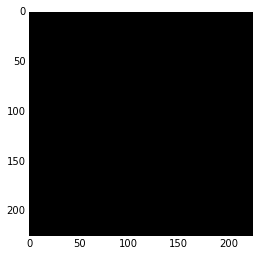

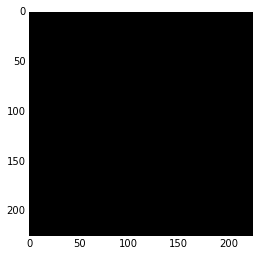

In [329]:
x = np.zeros_like(grad) * 255
for _ in range(4):
    probs = predict(x, n_preds=1)
    sign = compute_direction(probs)
    plt.figure()
    x = x - 0.2 * sign

In [318]:
predict(np.zeros_like(gr))

NameError: name 'gr' is not defined

In [ ]:
probs = predict(garbage_data)
plt.figure()
sign = compute_direction(probs)
predict(garbage_data - 0.99 * sign)


Helper functions for visualization

In [69]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

The input image

The first layer filters, `conv1`

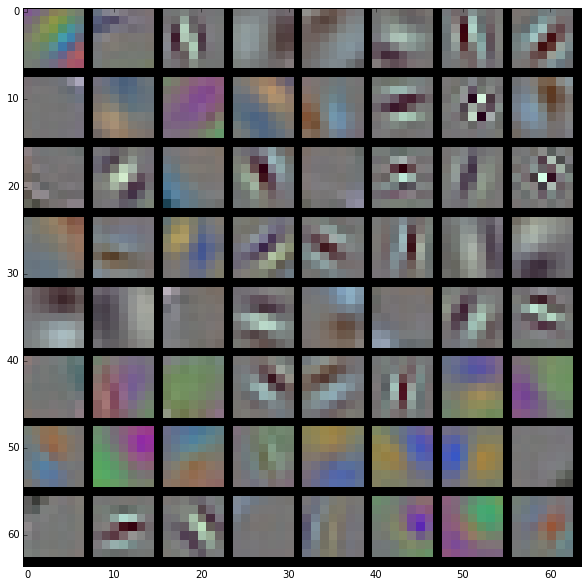

In [70]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1/7x7_s2'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

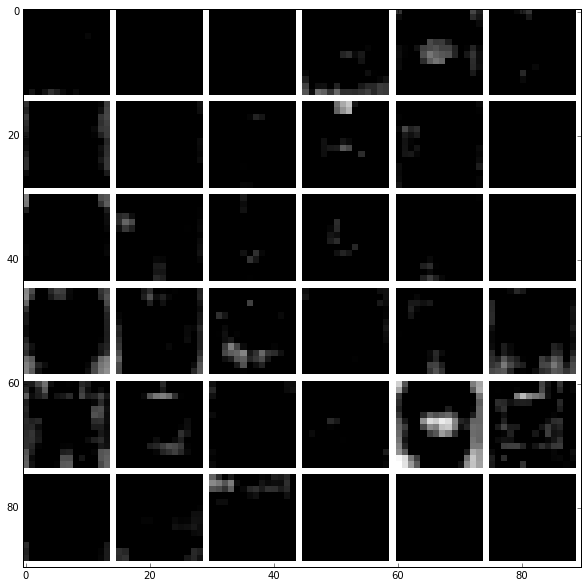

In [71]:
feat = net.blobs['inception_4a/pool_proj'].data[0, :36]
vis_square(feat, padval=1)

The second layer filters, `conv2`

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

In [74]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))

KeyError: 'conv2'

The second layer output, `conv2` (rectified, only the first 36 of 256 channels)

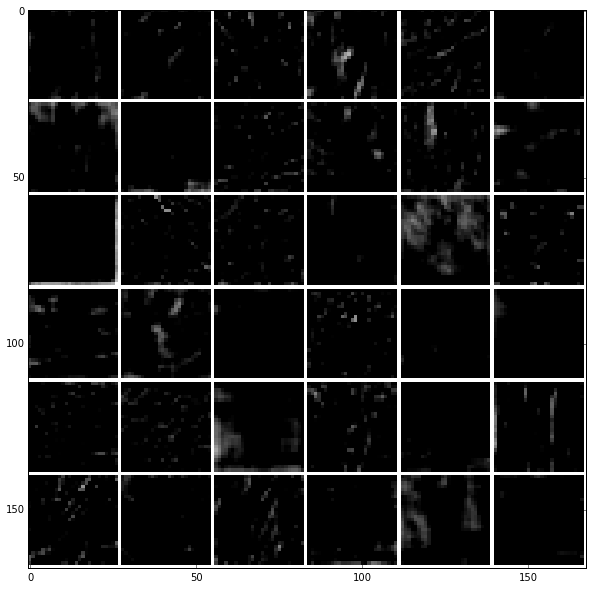

In [31]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

The third layer output, `conv3` (rectified, all 384 channels)

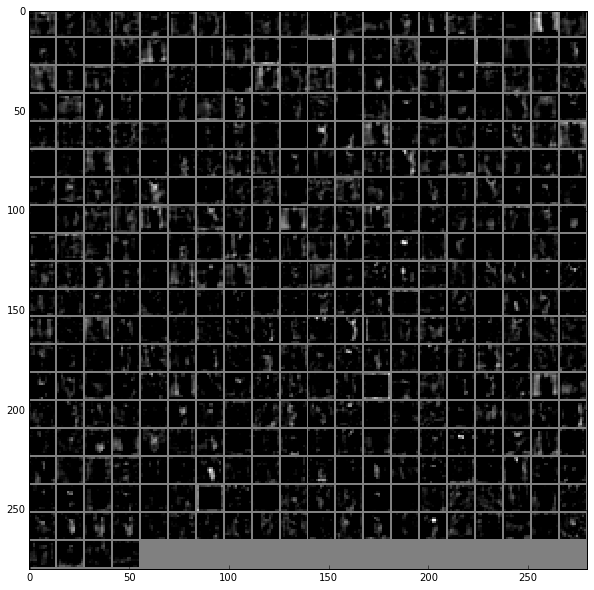

In [32]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

The fourth layer output, `conv4` (rectified, all 384 channels)

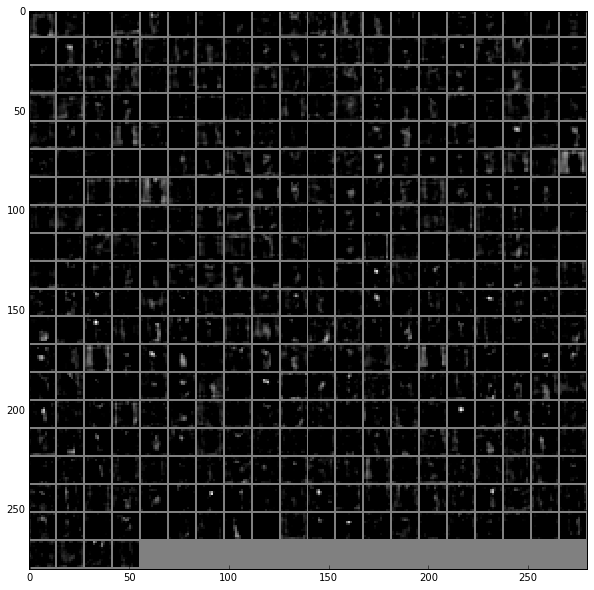

In [33]:
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

The fifth layer output, `conv5` (rectified, all 256 channels)

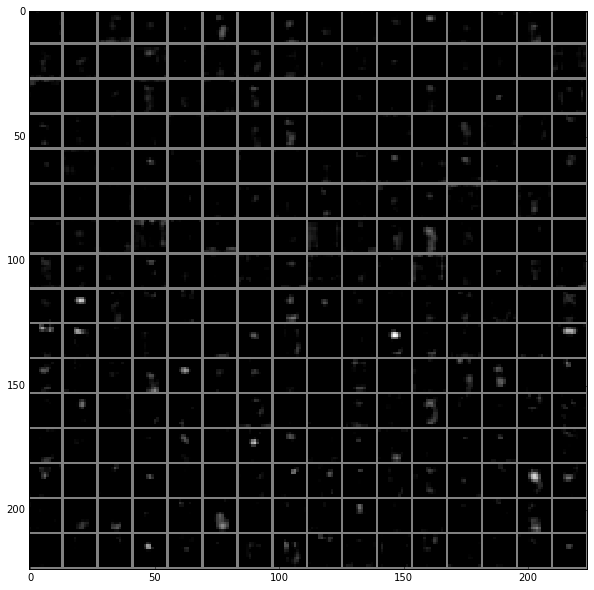

In [34]:
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)

The fifth layer after pooling, `pool5`

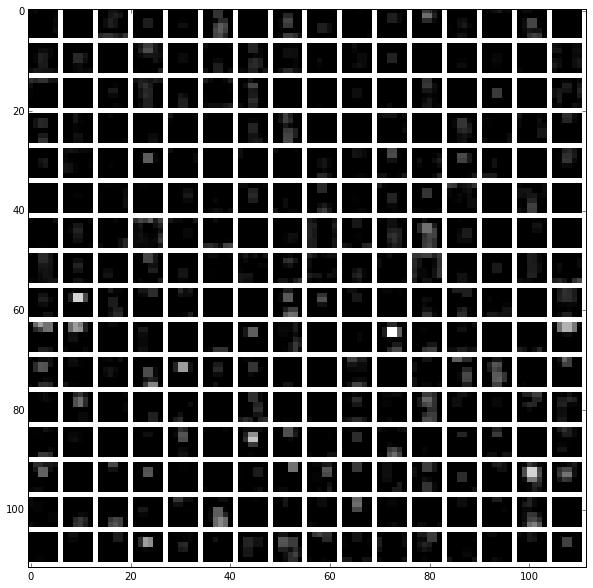

In [35]:
feat = net.blobs['pool5'].data[0]
vis_square(feat, padval=1)

The first fully connected layer, `fc6` (rectified)

We show the output values and the histogram of the positive values